In [2]:
%matplotlib inline


# Try Different EEG Algorithms


I'm a little frustrated with all this high frequency EEG data. Let's see if we can't learn something from these data mining techniques I've been working on. 



In [3]:
print(__doc__)
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
print('Setup Complete.')

Automatically created module for IPython interactive environment
Setup Complete.


## Assign Machine Learning Algorithms of Interest

In [4]:
h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

## Make our own classification set
Using Muse, let's generate a set from the 30 second demo and see what it looks like.

This is a nice little program to generate a data set from EEG.

In [5]:
import numpy as np  # Module that simplifies computations on matrices
import matplotlib.pyplot as plt  # Module used for plotting
from pylsl import StreamInlet, resolve_byprop  # Module to receive EEG data



import bci_workshop_tools as BCIw  # Our own functions for the workshop
import winsound
frequency = 2500  # Set Frequency To 2500 Hertz
duration = 1000  # Set Duration To 1000 ms == 1 second

ModuleNotFoundError: No module named 'pylsl'

In [5]:
def gen_EEG_dataset(feature_matrix_0, feature_matrix_1):
    """Generate an EEG dataset for binary classification. 

    Allows external classification algorithm to be used

    Args:
        feature_matrix_0 (numpy.ndarray): array of shape (n_samples,
            n_features) with examples for Class 0
        feature_matrix_0 (numpy.ndarray): array of shape (n_samples,
            n_features) with examples for Class 1
    Returns:
        X: input EEG power data 
        Y: labeled samples

    """
    # Create vector Y (class labels)
    class0 = np.zeros((feature_matrix_0.shape[0], 1))
    class1 = np.ones((feature_matrix_1.shape[0], 1))

    # Concatenate feature matrices and their respective labels
    y = np.concatenate((class0, class1), axis=0)
    features_all = np.concatenate((feature_matrix_0, feature_matrix_1),
                                  axis=0)

    # Normalize features columnwise
    mu_ft = np.mean(features_all, axis=0)
    std_ft = np.std(features_all, axis=0)

    X = (features_all - mu_ft) / std_ft
    return X, y

In [6]:
if __name__ == "__main__":

    """ 1. CONNECT TO EEG STREAM """

    # Search for active LSL stream
    print('Looking for an EEG stream...')
    streams = resolve_byprop('type', 'EEG', timeout=2)
    if len(streams) == 0:
        raise RuntimeError('Can\'t find EEG stream.')

    # Set active EEG stream to inlet and apply time correction
    print("Start acquiring data")
    inlet = StreamInlet(streams[0], max_chunklen=12)
    eeg_time_correction = inlet.time_correction()

    # Get the stream info, description, sampling frequency, number of channels
    info = inlet.info()
    description = info.desc()
    fs = int(info.nominal_srate())
    n_channels = info.channel_count()

    # Get names of all channels
    ch = description.child('channels').first_child()
    ch_names = [ch.child_value('label')]
    for i in range(1, n_channels):
        ch = ch.next_sibling()
        ch_names.append(ch.child_value('label'))

    """ 2. SET EXPERIMENTAL PARAMETERS """

    # Length of the EEG data buffer (in seconds)
    # This buffer will hold last n seconds of data and be used for calculations
    buffer_length = 15

    # Length of the epochs used to compute the FFT (in seconds)
    epoch_length = 1

    # Amount of overlap between two consecutive epochs (in seconds)
    overlap_length = 0.8

    # Amount to 'shift' the start of each next consecutive epoch
    shift_length = epoch_length - overlap_length

    # Index of the channel (electrode) to be used
    # 0 = left ear, 1 = left forehead, 2 = right forehead, 3 = right ear
    index_channel = [0, 1, 2, 3]
    # Name of our channel for plotting purposes
    ch_names = [ch_names[i] for i in index_channel]
    n_channels = len(index_channel)

    # Get names of features
    # ex. ['delta - CH1', 'pwr-theta - CH1', 'pwr-alpha - CH1',...]
    feature_names = BCIw.get_feature_names(ch_names)

    # Number of seconds to collect training data for (one class)
    training_length = 30

    """ 3. RECORD TRAINING DATA """

    # Record data for mental activity 0
    #winsound.Beep(400,1000)
    eeg_data0, timestamps0 = inlet.pull_chunk(
            timeout=training_length+1, max_samples=fs * training_length)
    eeg_data0 = np.array(eeg_data0)[:, index_channel]

    print('\n Stimuli \n')

    # Record data for mental activity 1
    winsound.Beep(400,1000) # Beep sound
    eeg_data1, timestamps1 = inlet.pull_chunk(
            timeout=training_length+1, max_samples=fs * training_length)
    eeg_data1 = np.array(eeg_data1)[:, index_channel]

    # Divide data into epochs
    eeg_epochs0 = BCIw.epoch(eeg_data0, epoch_length * fs,
                             overlap_length * fs)
    eeg_epochs1 = BCIw.epoch(eeg_data1, epoch_length * fs,
                             overlap_length * fs)

    """ 4. COMPUTE FEATURES AND TRAIN CLASSIFIER """

    feat_matrix0 = BCIw.compute_feature_matrix(eeg_epochs0, fs)
    feat_matrix1 = BCIw.compute_feature_matrix(eeg_epochs1, fs)

    [X_eeg, y_eeg] = gen_EEG_dataset(
            feat_matrix0, feat_matrix1)

    winsound.Beep(500,1000)

Looking for an EEG stream...
Start acquiring data

 Stimuli 



In [1]:
feature_names=BCIw.get_feature_names(ch_names)
feature_names.append('Label')

NameError: name 'BCIw' is not defined

## Data analysis
Split the data up into training and test sets. A little pandas makes things smooth.

In [59]:
import pickle as pickle
to_Pandas=np.concatenate((X_eeg,y_eeg), axis=1)
EEG_data=pd.DataFrame(to_Pandas)
EEG_data.columns=[feature_names]

os.makedirs('tmp', exist_ok=True)
EEG_data.to_pickle('tmp/EEG_data.pkl')
EEG_data=pd.read_pickle('tmp/EEG_data.pkl')
EEG_data.head()

delta-TP9 delta-AF7 delta-AF8 delta-TP10 theta-TP9 theta-AF7 theta-AF8  \
0 -0.741629 -0.246832 -1.003123  -0.737919 -0.071679 -0.278388 -0.394917   
1 -0.465159 -0.375829 -0.675690  -0.994917  0.421837 -0.266384 -0.342588   
2 -0.300360 -0.593103 -0.230169  -1.178920  0.575707 -0.558008 -0.511575   
3 -1.199469 -0.052362 -0.050335  -0.147744  0.363066 -0.747968 -0.596279   
4 -1.179414 -0.567211 -0.264939  -0.287595  0.107195 -0.584624 -0.450036   

  theta-TP10 alpha-TP9 alpha-AF7 alpha-AF8 alpha-TP10  beta-TP9  beta-AF7  \
0  -0.702859 -0.064687 -0.089727 -0.253414  -0.329490 -0.274620 -0.540724   
1  -0.845459  0.641567 -0.051474 -0.438131   0.088700  0.614017 -0.467101   
2  -0.775088  0.890561  0.004074 -0.350202   0.449000  0.755176 -0.152893   
3  -0.315677  0.133238 -0.516546 -0.515013   0.152953 -0.142528 -0.421535   
4   0.108202  0.127840 -0.487325 -0.257673   0.431552 -0.533677 -0.338436   

   beta-AF8 beta-TP10 Label  
0 -0.595515 -0.496981   0.0  
1 -0.501023 -0.752173   0.0  
2 -0.012223 -1.074821   0.0  
3  0.006353 -0.661817   0.0  
4  0.064754 -0.640054   0.0

In [60]:
X=X_eeg
y=y_eeg
linearly_separable = (X_eeg, y_eeg)

datasets = [linearly_separable]

In [61]:
for ds_cnt, ds in enumerate(datasets):
    print('Moose')
    #Remants of some old code.
figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
X, y = ds

X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

Moose


<Figure size 1944x648 with 0 Axes>

In [ ]:
figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
X, Y = ds

X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
# just plot the dataset first
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
ax = plt.subplot(len(datasets), len(classifiers) + 1, 1)
if ds_cnt == 0:
    ax.set_title("0-1")
# Plot the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=np.ravel(y_train), cmap=cm_bright,
            edgecolors='k')
# Plot the testing points
ax.scatter(X_test[:, 0], X_test[:, 1], c=np.ravel(y_test), cmap=cm_bright, alpha=0.6,
            edgecolors='k')

#second plot
ax = plt.subplot(len(datasets), len(classifiers) + 1, 2)
ax.set_title("0-2")
ax.scatter(X_train[:, 0], X_train[:, 2], c=np.ravel(y_train), cmap=cm_bright, 
            edgecolors='k')
ax.scatter(X_test[:, 0], X_test[:, 2], c=np.ravel(y_test), cmap=cm_bright, alpha=0.6,
            edgecolors='k')
#third plot
ax = plt.subplot(len(datasets), len(classifiers) + 1, 3)
ax.set_title("0-3")
ax.scatter(X_train[:, 0], X_train[:, 3], c=np.ravel(y_train), cmap=cm_bright, 
            edgecolors='k')
ax.scatter(X_test[:, 0], X_test[:, 3], c=np.ravel(y_test), cmap=cm_bright, alpha=0.6,
            edgecolors='k')

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
i += 1
y_test=np.ravel(y_test)
y_train=np.ravel(y_train)

ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)

## Run ML Script
Iterate over lots of different ML algorithms so we can compare.

In [63]:
X, y = ds
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.4, random_state=42)
y_test=np.ravel(y_test)
y_train=np.ravel(y_train)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                    np.arange(y_min, y_max, h))

score_save = []
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    score_save.append(score)
print(score_save)

[0.6741573033707865, 0.6067415730337079, 0.5730337078651685, 0.7078651685393258, 0.5730337078651685, 0.550561797752809, 0.7191011235955056, 0.5730337078651685, 0.6067415730337079, 0.7303370786516854]


In [64]:
dummy_data1 = {
        'Method': names,
        'Score': score_save}
results_data = pd.DataFrame(dummy_data1, columns = ['Method', 'Score'])

results_data

Method     Score
0  Nearest Neighbors  0.674157
1         Linear SVM  0.606742
2            RBF SVM  0.573034
3   Gaussian Process  0.707865
4      Decision Tree  0.573034
5      Random Forest  0.550562
6         Neural Net  0.719101
7           AdaBoost  0.573034
8        Naive Bayes  0.606742
9                QDA  0.730337

## Useless huge data comparison plot 
Compares all 16 input vectors against each other. Looking for major trends in shape. 

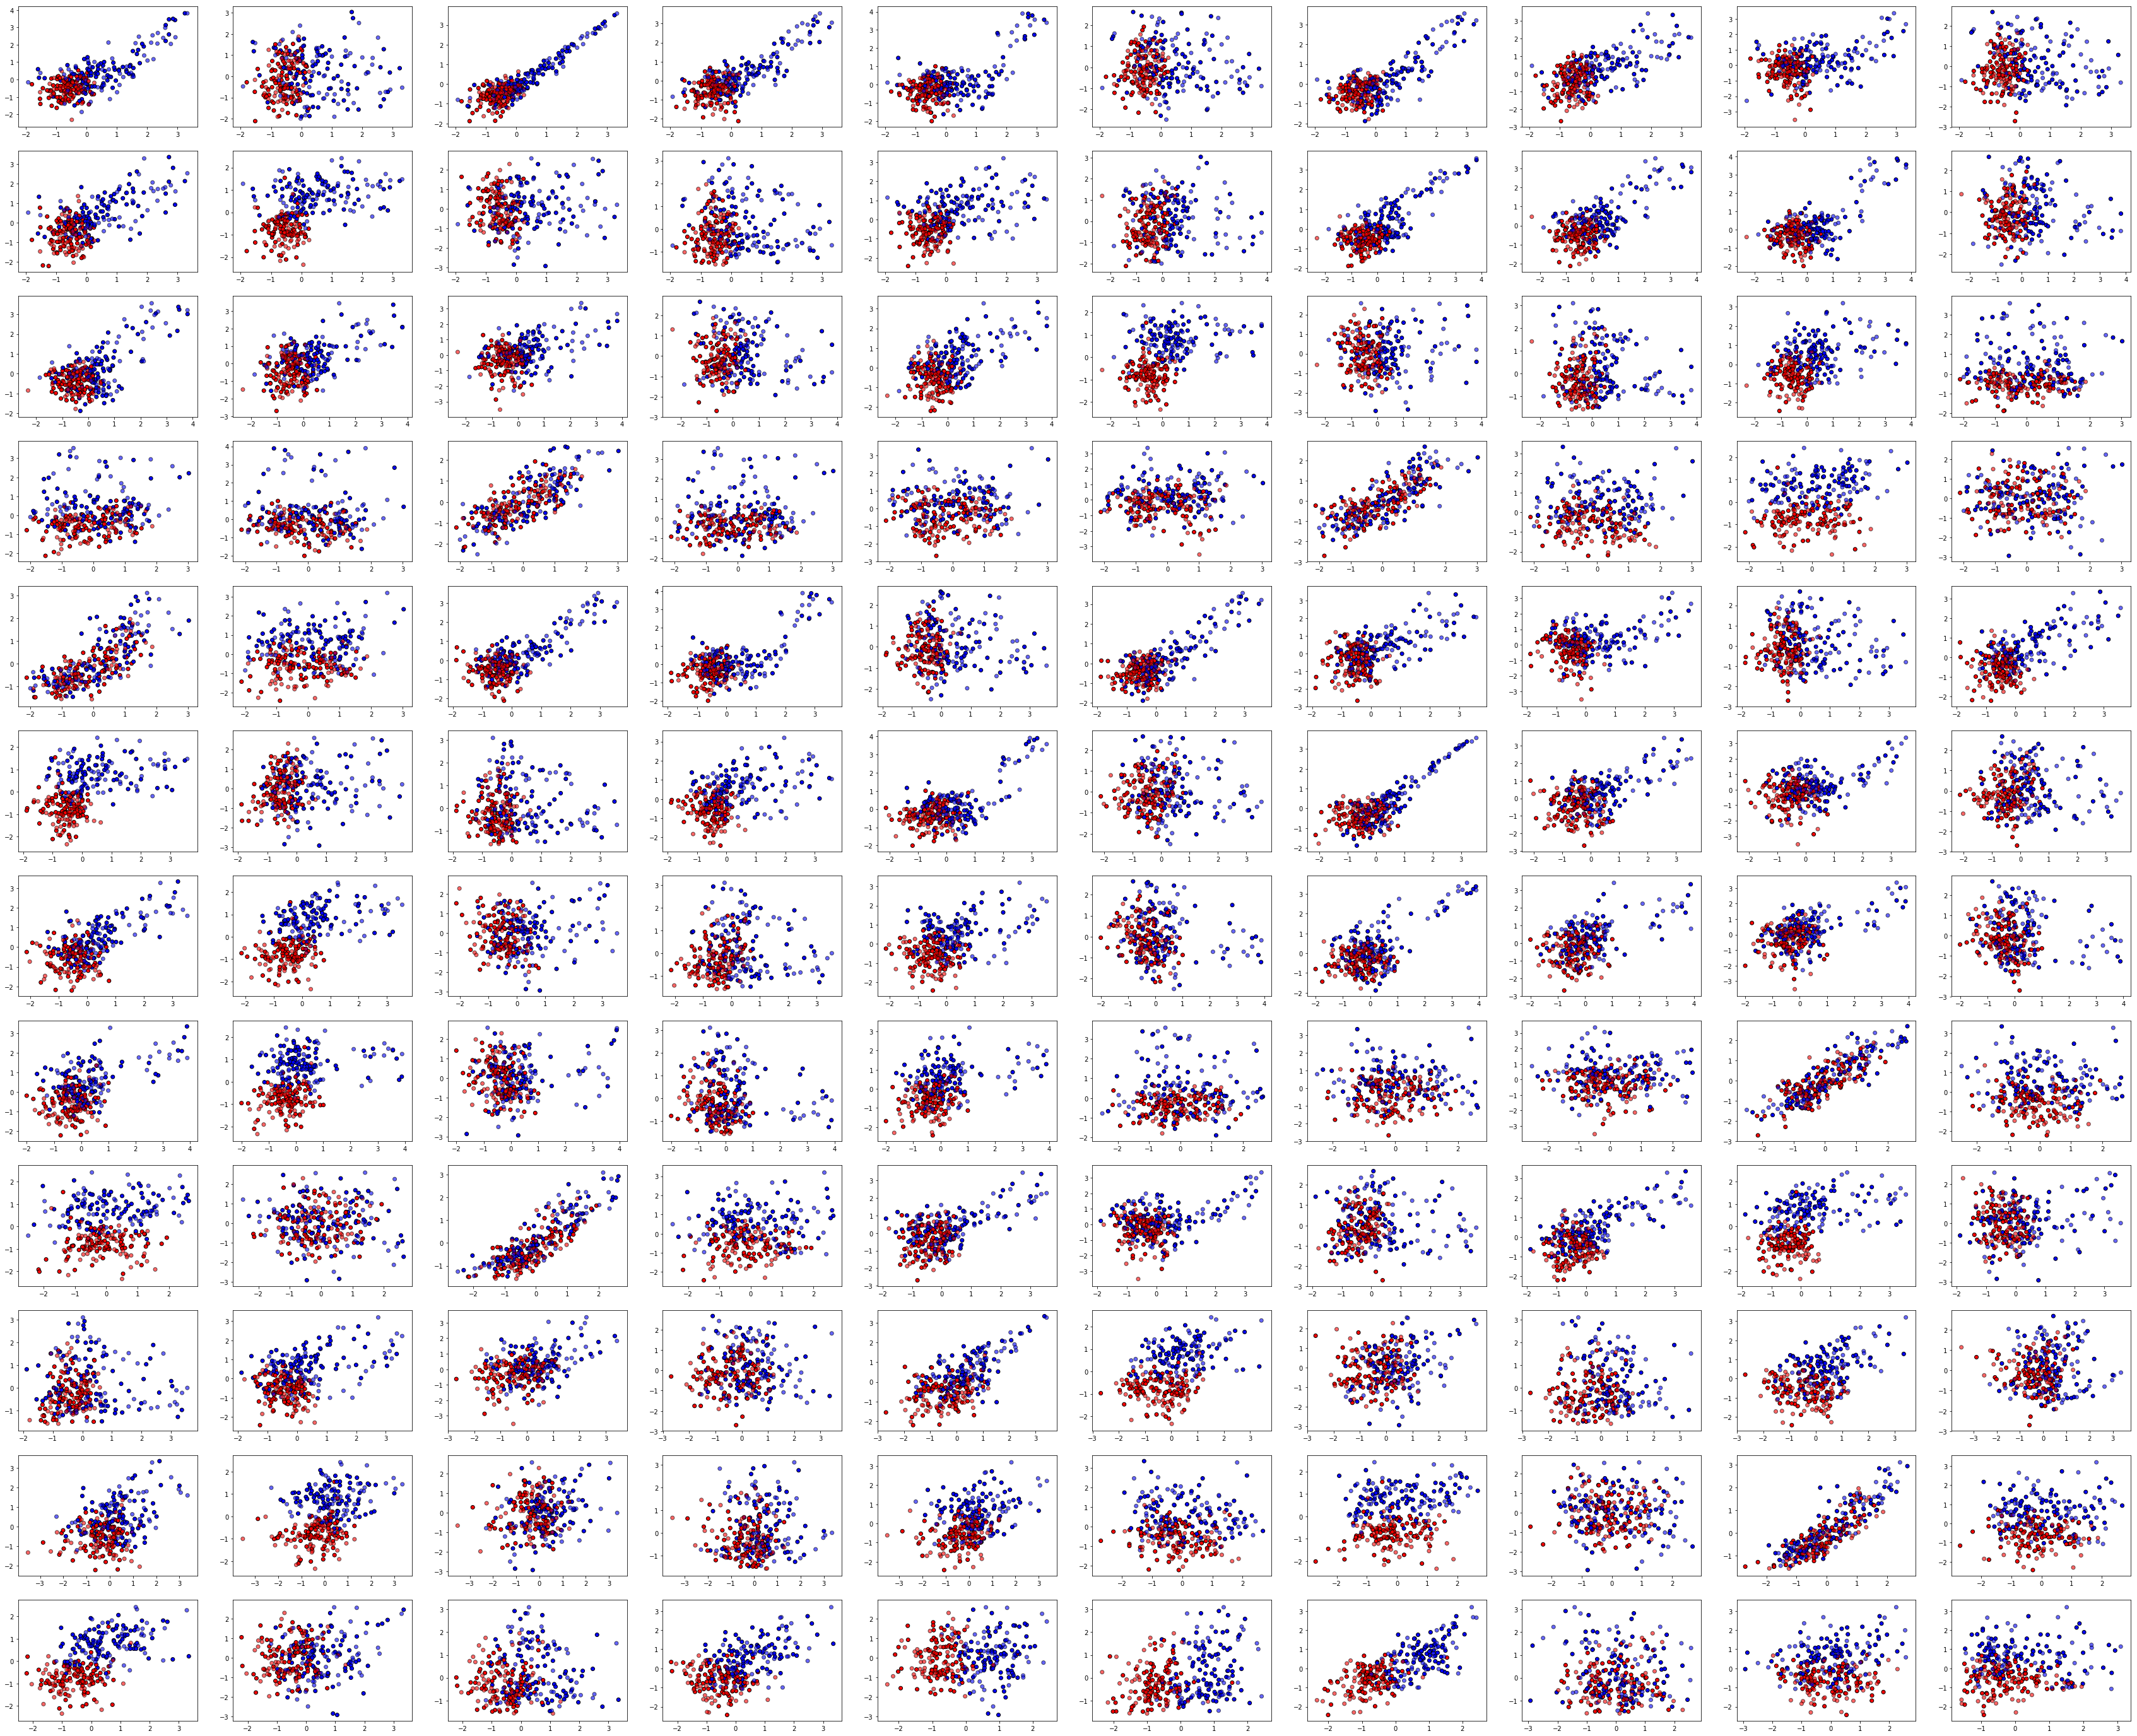

In [37]:
figure = plt.figure(figsize=(60, 50))
i=1
#third plot
while i<X_train.shape[1]:
    ax = plt.subplot(12, 10, i)
    #ax.set_title("0-3")
    ax.scatter(X_train[:, 0], X_train[:, i], c=np.ravel(y_train), cmap=cm_bright, 
            edgecolors='k')
    ax.scatter(X_test[:, 0], X_test[:, i], c=np.ravel(y_test), cmap=cm_bright, alpha=0.6,
            edgecolors='k')
    #print(i)
    i += 1

i=2
while i<X_train.shape[1]:
    ax = plt.subplot(12, 10, i+14)
    #ax.set_title("0-3")
    ax.scatter(X_train[:, 1], X_train[:, i], c=np.ravel(y_train), cmap=cm_bright, 
            edgecolors='k')
    ax.scatter(X_test[:, 1], X_test[:, i], c=np.ravel(y_test), cmap=cm_bright, alpha=0.6,
            edgecolors='k')
    #print(i)
    i += 1
    
i=3
while i<X_train.shape[1]:
    ax = plt.subplot(12, 10, i+27)
    #ax.set_title("0-3")
    ax.scatter(X_train[:, 2], X_train[:, i], c=np.ravel(y_train), cmap=cm_bright, 
            edgecolors='k')
    ax.scatter(X_test[:, 2], X_test[:, i], c=np.ravel(y_test), cmap=cm_bright, alpha=0.6,
            edgecolors='k')
    #print(i)
    i += 1
    
i=4
while i<X_train.shape[1]:
    ax = plt.subplot(12, 10, i+39)
    #ax.set_title("0-3")
    ax.scatter(X_train[:, 3], X_train[:, i], c=np.ravel(y_train), cmap=cm_bright, 
            edgecolors='k')
    ax.scatter(X_test[:, 3], X_test[:, i], c=np.ravel(y_test), cmap=cm_bright, alpha=0.6,
            edgecolors='k')
    #print(i)
    i += 1
    
i=5
while i<X_train.shape[1]:
    ax = plt.subplot(12, 10, i+50)
    #ax.set_title("0-3")
    ax.scatter(X_train[:, 4], X_train[:, i], c=np.ravel(y_train), cmap=cm_bright, 
            edgecolors='k')
    ax.scatter(X_test[:, 4], X_test[:, i], c=np.ravel(y_test), cmap=cm_bright, alpha=0.6,
            edgecolors='k')
    #print(i)
    i += 1
    
i=6
while i<X_train.shape[1]:
    ax = plt.subplot(12, 10, i+60)
    #ax.set_title("0-3")
    ax.scatter(X_train[:, 5], X_train[:, i], c=np.ravel(y_train), cmap=cm_bright, 
            edgecolors='k')
    ax.scatter(X_test[:, 5], X_test[:, i], c=np.ravel(y_test), cmap=cm_bright, alpha=0.6,
            edgecolors='k')
    #print(i)
    i += 1
    
i=7
while i<X_train.shape[1]:
    ax = plt.subplot(12, 10, i+69)
    #ax.set_title("0-3")
    ax.scatter(X_train[:, 6], X_train[:, i], c=np.ravel(y_train), cmap=cm_bright, 
            edgecolors='k')
    ax.scatter(X_test[:, 6], X_test[:, i], c=np.ravel(y_test), cmap=cm_bright, alpha=0.6,
            edgecolors='k')
    #print(i)
    i += 1
i=8
while i<X_train.shape[1]:
    ax = plt.subplot(12, 10, i+77)
    #ax.set_title("0-3")
    ax.scatter(X_train[:, 7], X_train[:, i], c=np.ravel(y_train), cmap=cm_bright, 
            edgecolors='k')
    ax.scatter(X_test[:, 7], X_test[:, i], c=np.ravel(y_test), cmap=cm_bright, alpha=0.6,
            edgecolors='k')
    #print(i)
    i += 1
    
i=9
while i<X_train.shape[1]:
    ax = plt.subplot(12, 10, i+84)
    #ax.set_title("0-3")
    ax.scatter(X_train[:, 8], X_train[:, i], c=np.ravel(y_train), cmap=cm_bright, 
            edgecolors='k')
    ax.scatter(X_test[:, 8], X_test[:, i], c=np.ravel(y_test), cmap=cm_bright, alpha=0.6,
            edgecolors='k')
    #print(i)
    i += 1
i=10
while i<X_train.shape[1]:
    ax = plt.subplot(12, 10, i+90)
    #ax.set_title("0-3")
    ax.scatter(X_train[:, 9], X_train[:, i], c=np.ravel(y_train), cmap=cm_bright, 
            edgecolors='k')
    ax.scatter(X_test[:, 9], X_test[:, i], c=np.ravel(y_test), cmap=cm_bright, alpha=0.6,
            edgecolors='k')
    #print(i)
    i += 1
i=11
while i<X_train.shape[1]:
    ax = plt.subplot(12, 10, i+95)
    #ax.set_title("0-3")
    ax.scatter(X_train[:, 10], X_train[:, i], c=np.ravel(y_train), cmap=cm_bright, 
            edgecolors='k')
    ax.scatter(X_test[:, 10], X_test[:, i], c=np.ravel(y_test), cmap=cm_bright, alpha=0.6,
            edgecolors='k')
    #print(i)
    i += 1
i=12
while i<X_train.shape[1]:
    ax = plt.subplot(12, 10, i+99)
    #ax.set_title("0-3")
    ax.scatter(X_train[:, 11], X_train[:, i], c=np.ravel(y_train), cmap=cm_bright, 
            edgecolors='k')
    ax.scatter(X_test[:, 11], X_test[:, i], c=np.ravel(y_test), cmap=cm_bright, alpha=0.6,
            edgecolors='k')
    #print(i)
    i += 1
i=13
while i<X_train.shape[1]:
    ax = plt.subplot(12, 10, i+102)
    #ax.set_title("0-3")
    ax.scatter(X_train[:, 12], X_train[:, i], c=np.ravel(y_train), cmap=cm_bright, 
            edgecolors='k')
    ax.scatter(X_test[:, 12], X_test[:, i], c=np.ravel(y_test), cmap=cm_bright, alpha=0.6,
            edgecolors='k')
    #print(i)
    i += 1
i=14
while i<X_train.shape[1]:
    ax = plt.subplot(12, 10, i+104)
    #ax.set_title("0-3")
    ax.scatter(X_train[:, 13], X_train[:, i], c=np.ravel(y_train), cmap=cm_bright, 
            edgecolors='k')
    ax.scatter(X_test[:, 13], X_test[:, i], c=np.ravel(y_test), cmap=cm_bright, alpha=0.6,
            edgecolors='k')
    #print(i)
    i += 1
i=15
while i<X_train.shape[1]:
    ax = plt.subplot(12, 10, i+105)
    #ax.set_title("0-3")
    ax.scatter(X_train[:, 14], X_train[:, i], c=np.ravel(y_train), cmap=cm_bright, 
            edgecolors='k')
    ax.scatter(X_test[:, 14], X_test[:, i], c=np.ravel(y_test), cmap=cm_bright, alpha=0.6,
            edgecolors='k')
    #print(i)
    i += 1
plt.savefig('EEG_combo_plots.pdf')
    

# Conclusions
So I've learned that's is kinda tricky to visualize the decision boundary with this many vectors. Instead, let's run through the fastai bulldozer procedure and see if we can't learn something there. Random forrest isn't the best classifer in this case, but it's still ok, and I'm very familar.

11.333333333333334